In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

A typical and repetetive process in every deep learning project is training the neural network model. The basic 

Training neural networks is usually considered an art or [epistimilogy is some cases](https://www.youtube.com/watch?v=gG5NCkMerHU). Most of the times when working on deep learning applications, its desired that we focus on solving our problem rather than figuring out how to best train the network we come up with. Also, we do not want to write a new training loop for every new project. In that spirit, Let's define `some classes and functions` for getting `Data` in a `usable` format for `training with mini-batch SGD using backpropogation.` This will allow us to add best practices in training a model that can be shared across multiple project.

- [data-vis course](https://www.kaggle.com/learn/data-visualization-from-non-coder-to-coder)
- [Advance NLP with spacy](https://www.datacamp.com/courses/advanced-nlp-with-spacy)

### Imports

In [2]:
import warnings 
warnings.filterwarnings('ignore')

In [3]:
#export
from torch import tensor
from torch import optim 
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [4]:
#export
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
import time
from functools import partial

In [5]:
#export
from fastai import datasets

In [6]:
#export
from fastprogress import master_bar, progress_bar
from fastprogress.fastprogress import format_time

### Metrics

In [7]:
#export
def accuracy(out, yb): return (torch.argmax(out, dim=1)==yb).float().mean()

### Data, Model and Optimizer

Every machine learning project starts with gathering data that we would like to analyze and build models on.

First, we will define a function called `get_data` that get's (downloads) our data and converts it into tensor format so that we can utilize our GPU's.

In [8]:
#export
def get_mnist_data(MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'):
    path = datasets.download_data(MNIST_URL, ext='.gz')
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return map(tensor, (x_train,y_train,x_valid,y_valid))

In order to iterate through our dataset one mini-batch at a time efficiently and in a readable way, We will use `Pytorch's Dataloader` class which is a generator generating our x's and y's on mini-batch at a time. Dataloader expects a Dataset which is a class that allows to index into the dataset to grab a specfic data point. This can be implemented by overriding `__getitem__` function of the class. We will also override `__len__` function to make it easy to get total length of out dataset.

In [9]:
#export
class Dataset():
    def __init__(self, x, y): self.x,self.y = x,y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i],self.y[i]

Let's also write a convienient function that takes training dataset and validation dataset and return respective dataloaders. We will also `shuffle` our training set every epoch to introduce some randomisation so that network doesn't learn's a specific order in our data. The Dataloader class also take a parameter `batch_size` which is usually determined by memory of the GPU's we have. Because, we never do backprop during validation set, we can have the `double batch_size` during that period as compared to training phase.

In [10]:
#export
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=4, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, num_workers=4, **kwargs))

Now' lets wrap our dataloaders into a `Databunch` class which just acts as a storage device. We will also make the underlying dataset accesible so that if we want to change it later, we can. Why would we want to do that is an excersise for the reader ;). One will also notice a variable called `c_out`, which is basically the number of classes we are trying to classify. We can automatically detect this from our `labels`, so why not just automate it so that we can decide last layer's number of outputs automatically !.

In [11]:
#export
class DataBunch():
    def __init__(self, train_dl, valid_dl, c_out=None):
        self.train_dl,self.valid_dl,self.c_out = train_dl,valid_dl,c_out
        
    @property
    def train_ds(self): return self.train_dl.dataset
        
    @property
    def valid_ds(self): return self.valid_dl.dataset

Now let's use our functions to get the databunch. Along the we will also see what each of the functions and classes defined above takes as input and produces as output.

First, we will use `get_data` function so that we can have our data in tensor format.

In [12]:
x_train,y_train,x_valid,y_valid = get_mnist_data()

Now, lets check the shapes of things returned by `get_data` function.

In [13]:
x_train.shape , y_train.shape, x_valid.shape, y_valid.shape

(torch.Size([50000, 784]),
 torch.Size([50000]),
 torch.Size([10000, 784]),
 torch.Size([10000]))

As you might have guessed if you are following along, here we are working with MNIST dataset. Why ?? We need a toy dataset to quickly validate our infrastructure. The goal here is to build a flexible dataloading and training loop and not designing architectures.

So, we have `50000 x_train` datapoints each with `y_train`. The x's are flattened images of handwritten digits and the ys are their actual digits in those images.

Now lets create a Dataset for each of our training and validation dataset.

In [14]:
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

Now let's create our dataloaders, so that we can iterate through our dataset in mini-batches. We will define our batch_size to be equal to 512.

In [15]:
c = y_train.max().item()+1
bs=512
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

Since it's a classification task, we will be using `categorical_cross_entropy` function as our loss function.

In [16]:
loss_func = F.cross_entropy

In [17]:
nh = 50

Since our goal is little different in this notebook, we will just define a simple one layer neural network with hidden activation size of `50`. We also need a optimizer *(more on this in a later post)*. At a high level, optimizer is the thing resposible for updating out weights and biases while doing stochastic mini-batch gradient descent. Let's wrap the model and the optimizer in a convienient function called `get_model`.

In [18]:
#export
def get_model(data, nh=50, lr=0.1):
    m = data.train_ds.x.shape[1]
    model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, data.c_out))
    return model, optim.SGD(model.parameters(), lr=lr)

### A detour: Callbacks in Python

Let's write a utility function that converts a string in `CamelCase` format to a `Snake` format. We will use this functions to register our Callback's name with python in snake format.

In [19]:
#export
import re

_camel_re1 = re.compile('(.)([A-Z][a-z]+)')
_camel_re2 = re.compile('([a-z0-9])([A-Z])')
def camel2snake(name):
    s1 = re.sub(_camel_re1, r'\1_\2', name)
    s2 =  re.sub(_camel_re2, r'\1_\2', s1)
    return s2.lower()

Let's use this function on a couple of strings so that we get comfortable with it.

In [20]:
camel2snake("HelloWorldGoodMorningHowAreYou")

'hello_world_good_morning_how_are_you'

In [21]:
camel2snake("DeepLearningIsAmazing")

'deep_learning_is_amazing'

Let's write a function which calulates the sum of squares upto a given number. We will also sleep the process for 1 second, so that we can mimic a heavy processing function.

In [22]:
from time import sleep 

In [23]:
def sum_of_squares(n):
    res = 0
    for i in range(n+1):
        res += i*i
        sleep(1)
    return res

let's use the function to calulate some sum of squares.

In [24]:
%time sum_of_squares(3)

CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 4 s


14

The function took `4secs` to compute. Now, if you are as impatient as me...you would have liked to see what's happening while the result is being computed. Some kind of progress report ? Rather than bloating our core function with progress logic, we will write our progress logic in a different function and then pass that function to `sum_of_squares`. It can callback the progress function after every loop. We will have to edit our `sum_of_squares` function with a generic function call after the loop, so that it call any user passed function. 

In [25]:
def sum_of_squares(n, cb=None):
    res = 0
    for i in range(n+1):
        res += i*i
        sleep(1)
        if cb: cb(i)
    return res

Now let's write are `show_progress` function.

In [26]:
def show_progress(i):
    print(f"Awesome !!!, We have finished Epoch {i}")

Now let's call our sum of squares function with `show_progress` function.

In [27]:
%time sum_of_squares(3, show_progress)

Awesome !!!, We have finished Epoch 0
Awesome !!!, We have finished Epoch 1
Awesome !!!, We have finished Epoch 2
Awesome !!!, We have finished Epoch 3
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 4 s


14

Awesome, our function caluclated the same thing but this time we could see the progress it did also. Now, we will make our function and the callback `show_progress` more flexible. Next, let's add the functionality so that a user can define what `exclamation` they wish to define rather that our hardcoded `Awesome`.

In [28]:
def show_progress(exclamation, epoch):
    print(f"{exclamation} !!!, We have finished Epoch {epoch}")

Our `sum_of_squares` expects a callback that takes only one input where as our updated `show_progress` takes two. We will use `partials` to convert our function that takes two arguments into a function that take one argument. Partials allow us to partially apply a function. We can do this because functions are first order things in Python.

In [29]:
def make_show_progress(exclamation):
    def _inner(epoch):  print(f"{exclamation} !!!, We have finished Epoch {epoch}")
    return _inner

In [30]:
%time sum_of_squares(4, make_show_progress("Nice!"))

Nice! !!!, We have finished Epoch 0
Nice! !!!, We have finished Epoch 1
Nice! !!!, We have finished Epoch 2
Nice! !!!, We have finished Epoch 3
Nice! !!!, We have finished Epoch 4
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 5.01 s


30

Nice !!!, Let's try it with a different exclamation token.

In [31]:
%time sum_of_squares(4, make_show_progress("Terrific!"))

Terrific! !!!, We have finished Epoch 0
Terrific! !!!, We have finished Epoch 1
Terrific! !!!, We have finished Epoch 2
Terrific! !!!, We have finished Epoch 3
Terrific! !!!, We have finished Epoch 4
CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 5.01 s


30

Terrific !!!. It's kind of annoying that every time we call our function with the callback, we loose our stat in callback. Wouldn't it be nice to store things like how long our function took to complete. Let's convert our our callback function into a callback class so that we retain the state. 

In [32]:
class ProgressShowingCallback():
    def __init__(self, exclamation="Awesome"): self.exclamation = exclamation
    def __call__(self, epoch): print(f"{self.exclamation}! We've finished epoch {epoch}!")

In [33]:
cb = ProgressShowingCallback("Terrific")

In [34]:
sum_of_squares(4, cb)

Terrific! We've finished epoch 0!
Terrific! We've finished epoch 1!
Terrific! We've finished epoch 2!
Terrific! We've finished epoch 3!
Terrific! We've finished epoch 4!


30

We have introduced a new concept here. That `__call__` thingy. Python has some dunder functions *(yes, that's how we pronounce them)* that get called at some point in the objects lifecycle. `__call__` gets called when we use a object instance of that class as a function, like we did while calling `sum_of_squares` with `cb`. Adimitedly we could have defined a normal function like `callback` and then passed `cb.callback` but doesn't our approach makes things cleaner ? That's the only reason we defined our behaviour on `__call__`.

As you can probably notice by now: we have been able to modify behaviour of our `sum_of_squares` funtion by writing a completely seprate class and hence not bloating the calculation logic.

> This is what `Callbacks` allow us to do. `Modify the behaviour` of some underlying function by `writing seprate concise classes` hence keeping the underlying function concise, readable and error prone.

Now, you might be thingking hang on, where did we modify the behaviour of the function. Weren't we just priting stuff ? Yes, you are write. So let's fix that and also modify the behaviour of the `sum_of_squares` function.

Let's wrap our caculation inside a class called `ShowCalulator`. This will allow us to inject behaviour at multiple places during the computation with same callback. We initialize it with upto what `number we want sum of squares` and `optionally our callback`.

In [35]:
class SlowCalculator():
    def __init__(self, n, cb=None): self.n,self.cb,self.res = n,cb,0
    
    def __call__(self, cb_name, *args):
        if not self.cb: return
        cb = getattr(self.cb,cb_name, None)
        if cb: return cb(self, *args)

    def calc(self):
        for i in range(self.n+1):
            self('before_calc', i)
            self.res += i*i
            sleep(1)
            if self('after_calc', i):
                print("stopping early")
                break

Our `calc` function now has two `callback points`, called `before_calc` and `after_calc`. If the `after_calc` callback returns true, we will break and stop the computation *(modifying behaviour)*. Our ``__call__`` function now check with `getattr` if callabck has the function, if it has it calls that function. That's how we are able to get multiple callback points with one single callback.

Now, we can create our `Modifying Callback` which will have to points `before_calc` which will print result when computation is about to start and `after_calc` which will print result and when the result gets larger than 10 it will stop the computation.

In [36]:
class ModifyingCallback():
    
    def before_calc(self, calc, i):
        print(f"Starting Epoch {i}: res: {calc.res}")
        
    def after_calc (self, calc, epoch):
        print(f"After {epoch}: {calc.res}")
        if calc.res>10: return True
        if calc.res<3: calc.res = calc.res*2

In [37]:
calculator = SlowCalculator(5, ModifyingCallback())

In [38]:
calculator.calc()

Starting Epoch 0: res: 0
After 0: 0
Starting Epoch 1: res: 0
After 1: 1
Starting Epoch 2: res: 2
After 2: 6
Starting Epoch 3: res: 6
After 3: 15
stopping early


In [39]:
calculator.res

15

What we have implemented is a general purpose callback system that can be used to inject behaviour in the underlying class `(ShowCalculator)` at any number of points.

Since, in typical training loop of a deep learning system performs a set of predifined steps `(get a batch of data, pass it through the model, calculate loss function, calculate gradients using backprop, update parameters and zero gradients)`. So, we will use this concept to write a flexible training loop so that we can inject behaviour at any of those  of those predefined steps. 

### Callback class 

[Python's @property tutorial](https://www.programiz.com/python-programming/property)

Let's first write a base Callback class, that checks through `__call__`, if the function is there and if its present, it calls it. We will also change the name of callback from camel case to snake format. Let's not worry too much about `_order`, `set_runner` and `_getattr` at this moment. We will comeback to this later.

In [40]:
#export
class Callback():
    _order=0
    def set_runner(self, run): self.run=run
    def __getattr__(self, k): return getattr(self.run, k)
    
    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')
    
    def __call__(self, cb_name):
        f = getattr(self, cb_name, None)
        if f and f(): return True
        return False

Usually when we are training a model, we train it for a epoch and then evaluate it on the validation set. During validation we turn the model into evaluation format so that we do not update weights. Let's write our first callback to put model in training at the begining of epoch: `begin_epoch` and in validation: `begin_validate` function. 

In [41]:
#export
class TrainEvalCallback(Callback):
    def begin_fit(self):
        self.run.n_epochs=0.
        self.run.n_iter=0
    
    def after_batch(self):
        if not self.in_train: return
        self.run.n_epochs += 1./self.iters
        self.run.n_iter   += 1
        
    def begin_epoch(self):
        self.run.n_epochs=self.epoch
        self.model.train()
        self.run.in_train=True

    def begin_validate(self):
        self.model.eval()
        self.run.in_train=False

We might have to cancel the training either after `training`, after an `Epoch` or `Batch`. Let's define empty exception classes for each so that we can exit neatly at those points.

In [42]:
#export
class CancelTrainException(Exception): pass
class CancelEpochException(Exception): pass
class CancelBatchException(Exception): pass

Remember, we defined a `name` function in our base Callback class. This allows us to change the name of the class name to snake format and remove the training callback string.

In [43]:
TrainEvalCallback().name

'train_eval'

Now, let's define a utility function called `listify` which will turn a set of objects into a python `list`

In [44]:
#export
from typing import *

def listify(o):
    if o is None: return []
    if isinstance(o, list): return o
    if isinstance(o, str): return [o]
    if isinstance(o, Iterable): return list(o)
    return [o]

- https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev_course/dl2/09b_learner.ipynb
- https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev_course/dl2/04_callbacks.ipynb
- https://www.autodeskresearch.com/publications/samestats
- https://forums.fast.ai/uploads/default/original/3X/a/3/a3eecbbffd66da600b7ad0b2ad4250c8ed1a682c.png

A deep learning model has lot of surrounding pieces associated with, namely the `model`, `optimizer`, `loss_func` and `databunch`. Let's write a storage class called `Learner` which just stores all this which will make it easy for us to access these when required.

In [45]:
#export
class Learner():
    def __init__(self, model, opt, loss_func, data):
        self.model,self.opt,self.loss_func,self.data = model,opt,loss_func,data

### Runner: Writing a flexible training loop

Now, we will define our main class called `Runner`. It will be responsible for `registering callback`, `calling callbacks` at appropriate time and `carrying out the training of our model`. It has a lot of code, so we will discuss each function one by one.

- `Runner.__init__`: takes `cbs` a.k.a. *callbacks* and `cb_funcs` a.k.a *partially applied callback functions*.
    - It first turns the `cbs` into a list if they are not. 
    - Goes through each `cb_funcs`, calls it, sets the name atrribute to the callback use name function and appends to the list of callback
    - Registers a `stop` valiable and initializes to `False`.
    - Registers a `cbs variable with a list of callbacks ` that has TrainEvalCallback and cbs.
    
    
 
- `Runner.opt`: An accessor to `optimizer` inside the learner object.
- `Runner.model`: An accessor to `model` inside the learner object.
- `Runner.loss_func`: An accessor to `loss_func` inside the learner object.
- `Runner.data`: An accessor to `data` inside the learner object.


- `Runner.__call__`
    - Goes through all the registered callbacks in `self.cbs` in `_order`, and calls the callback and returns if the callback returns something.
    
    
- `Runner.all_batches`:
    - Registers a `iters` variable.
    - Loops through all the mini-batches in the dataloader and calls `one_batch`.
    
    
- `Runner.one_batch`:
    - It gets one batch of `x's` and `y's` and registers to the variable. 
    - Calls `begin_batch` callback functions for all registered callbacks. 
    - Passes the `xb` into the model and registers the result into `pred`. 
    - Calls `after_pred` callback functions for all registered callbacks. 
    - Calculates the loss between `pred` and `ys` using `loss_func` and register to the class.
    - Calls `after_loss` callback functions for all registered callbacks. 
    - Returns if the model is in `validation` mode, checked through `not self.in_train`.
    - Calls `after_loss` callback functions for all registered callbacks. 
    - Calculates the gradient with respect to the weights by calling `loss.backward()`.
    - Updates the parameters in the optimizer by calling `opt.step()`
    - Calls `after_step` callback functions for all registered callbacks. 
    - Zeros the gradients so there is accumlation for the next batch.
    - If the callbacks have a `CancelBatchException` then breaks calls `after_cancel_batch` callback functions for all registered callbacks.
    - And finally, calls `after_batch` callback functions for all registered callbacks.
    
- `Runner.fit`: 
    - Recieves, number of `epochs` to train for, the `learn` object.
    - Registers `epoch` and `learn`. Also initializes the `loss` to `0`. 
    - Tries:
        - Sets the runner object inside all the callbacks by looping through all of them and calling `set_runner` function. That's what `set_runner does that we defined in our base Callback function.
        - Calls `begin_fit` callback functions for all registered callbacks.
        - Iterates for epoch times, doing:
            - Calls `begin_epoch` callback functions for all registered callbacks.
            - If none of them break: goes on to call `all_batches` with the training data.
            - Then inside a with block to avoid calculating grad, Calls `begin_validate` callback functions for all registered callbacks. If none of them break then, 
            - Calls the `all_batches` on validation dataloader. 
            - Then, Calls `after_fit` callback functions for all registered callbacks.
    - If there is  `CancelTrainException`, then stops the training and calls `after_cancel_train` function for all the registered callbacks. 
    - Finally, calls `after_fit` function for all the registered callbacks.
    - And sets the `learn` object to none. So we dont accedently call fit again.

That completes our, possibly the longest class. It's ok if you didn't understand everything. Rewatch the `fast.ai` lecture again, read this again untill you understand.

In [46]:
#export
class Runner():
    def __init__(self, cbs=None, cb_funcs=None):
        cbs = listify(cbs)
        for cbf in listify(cb_funcs):
            cb = cbf()
            setattr(self, cb.name, cb)
            cbs.append(cb)
        self.stop,self.cbs = False,[TrainEvalCallback()]+cbs

    @property
    def opt(self):       return self.learn.opt
    @property
    def model(self):     return self.learn.model
    @property
    def loss_func(self): return self.learn.loss_func
    @property
    def data(self):      return self.learn.data

    def one_batch(self, xb, yb):
        try:
            self.xb,self.yb = xb,yb
            self('begin_batch')
            self.pred = self.model(self.xb)
            self('after_pred')
            self.loss = self.loss_func(self.pred, self.yb)
            self('after_loss')
            if not self.in_train: return
            self.loss.backward()
            self('after_backward')
            self.opt.step()
            self('after_step')
            self.opt.zero_grad()
        except CancelBatchException: self('after_cancel_batch')
        finally: self('after_batch')

    def all_batches(self, dl):
        self.iters = len(dl)
        try:
            for xb,yb in progress_bar(dl, parent=self.mbar): self.one_batch(xb, yb)
        except CancelEpochException: self('after_cancel_epoch')

    def fit(self, epochs, learn):
        self.epochs,self.learn,self.loss = epochs,learn,tensor(0.)

        try:
            for cb in self.cbs: cb.set_runner(self)
            self.mbar = master_bar(range(epochs))
            self('begin_fit')
            for epoch in self.mbar:
                self.epoch = epoch
                if not self('begin_epoch'): self.all_batches(self.data.train_dl)

                with torch.no_grad(): 
                    if not self('begin_validate'): self.all_batches(self.data.valid_dl)
                self('after_epoch')
            
        except CancelTrainException: self('after_cancel_train')
        finally:
            self('after_fit')
            self.learn = None

    def __call__(self, cb_name):
        res = False
        for cb in sorted(self.cbs, key=lambda x: x._order): res = cb(cb_name) and res
        return res

Now that we have written our training loop, we can train the our models. So let's train one.

In [47]:
model, opt = get_model(data)
learn = Learner(model, opt, loss_func, data)
run = Runner()

In [48]:
run.fit(5,learn)

Uh oh, what just happened ? We got back nothing. That's because we never printed or told our loop to report back stuff. But our `run` object has all the state we will want, we just need to intercept them at appropriate time during training and format them in a readable format.

In [49]:
run.epochs, run.in_train, run.iters, run.cbs, run.loss, run.pred.shape

(5,
 False,
 10,
 tensor(0.2900),
 torch.Size([784, 10]))

But aren't we supposed to track what happens after very epoch ? Yes. So, lets write a `callback` to report back to us some `metrics`. In particular we would like to see `train_loss`, `valid_loss`, `train_accuracy` and `valid_accuracy`.

### Stats Callback

As mentioned above, we need two sets of metrics one for train data and one for valid data. So lets write a class that will print `average statistics for each of the data loaders`. We wil call it surpise `AvgStats`. The only functions worth remembering are:

- `AvgStats.accumulate`:
    - It has the accesse to runner object, that means it has acces to every state in the learner object. 
    - first we figure out number of elements in the batch and assign it `bn`.
    - we multiply the loss by `bn` and add it to `tot_loss` (total_loss). 
    - we add `bn` to `cout` (that keeps track of total datapoints seen during training).
    - Then we caculate each metric by calling it with the predictions and labels and then multiply it by `bn`. 


- `AvgStats.avg_stats`: averages the metrics with total count of element seen during training. 

In [50]:
#export
class AvgStats():
    def __init__(self, metrics, in_train): self.metrics,self.in_train = listify(metrics),in_train
    
    def reset(self):
        self.tot_loss,self.count = 0.,0
        self.tot_mets = [0.] * len(self.metrics)
        
    @property
    def all_stats(self): return [self.tot_loss.item()] + self.tot_mets
    @property
    def avg_stats(self): return [o/self.count for o in self.all_stats]
    
    def __repr__(self):
        if not self.count: return ""
        return f"{'train' if self.in_train else 'valid'}: {self.avg_stats}"

    def accumulate(self, run):
        bn = run.xb.shape[0]
        self.tot_loss += run.loss * bn
        self.count += bn
        for i,m in enumerate(self.metrics):
            self.tot_mets[i] += m(run.pred, run.yb) * bn

Now that we have our function calculate average statistics, we can write our callback that will help us to intercept metrics as our model trains and print them at the end of every epoch. We will call our callback `AvgStatsCallback`.

- `AvgStatsCallback.__init__`:
    - registers and initializes `AvgStats` for both train data and valid data. Note: since `AvgStats` takes a list of metrics and `in_train` variable we pass `True` for training and `False` for validation set.
    
- `AvgStatsCallback.begin_epoch`:
    - resets the metric classes for both set of data and starts the timer.
    
- `AvgStatsCallback.after_loss`:
    - After loss has been calculated in our training loop, it accumulates the stats for the data. Note we do that in with no grad block because we do not want to affect our graidients as `backward` hasn't been called yet. 
    
- `AvgStatsCallback.after_epoch`:
    - We prepare the stats to be printed.
    - Also calculate the time taken for whole epoch. 
    - We finally print the stats for the last epoch.


In [51]:
#export
class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats,self.valid_stats = AvgStats(metrics,True),AvgStats(metrics,False)
    
    def begin_fit(self):
        met_names = ['loss'] + [m.__name__ for m in self.train_stats.metrics]
        names = ['epoch'] + [f'train_{n}' for n in met_names] + [f'valid_{n}' for n in met_names] + ['time']
        self.mbar.write(names, table=True)
    
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        self.start_time = time.time()
        
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)
    
    def after_epoch(self):
        stats = [str(self.epoch)] 
        for o in [self.train_stats, self.valid_stats]: stats += [f'{v:.6f}' for v in o.avg_stats] 
        stats += [format_time(time.time() - self.start_time)]
        self.mbar.write(stats, table=True)

Now that we have our metric reporting callback, let's use it to see some metrics while we train our model.

In [52]:
model, opt = get_model(data)
learn = Learner(model, opt, loss_func, data)
# we call it using partial beause it takes the name of metric we want to calculate
cb_funcs = [partial(AvgStatsCallback, accuracy)] 
run = Runner(cb_funcs=cb_funcs)

In [53]:
run.fit(7, learn)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.278114,0.703860,0.583156,0.867600,00:01
1,0.507794,0.871260,0.391459,0.899300,00:01
2,0.399913,0.890080,0.340323,0.908800,00:01
3,0.358203,0.899800,0.313430,0.913600,00:01
4,0.333751,0.905340,0.299343,0.915500,00:01
5,0.316684,0.909680,0.284148,0.919300,00:01
6,0.302604,0.913640,0.274289,0.923100,00:01


And Voila, we get the metric we asked for for each epoch. Note we also get the total training time.

### Plotting hyperparams and losses

It would be nice if we can see how our loss varies during training in a plot and also see how our hyper-params change during training. We can do this with callbacks :). Let's write another callback, that records the losses during training and also the learning rate so that we can plot them later.

- `Recorder.after_batch`:
    - Appends the training loss to a list `self.losses`.
    - Also appends the `learning rate` used for that batch.

In [54]:
#export
class Recorder(Callback):
    def begin_fit(self):
        self.lrs = [[] for _ in self.opt.param_groups]
        self.losses = []

    def after_batch(self):
        if not self.in_train: return
        for pg,lr in zip(self.opt.param_groups,self.lrs): lr.append(pg['lr'])
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self, pgid=-1): plt.plot(self.lrs[pgid])
    def plot_loss(self, skip_last=0): plt.plot(self.losses[:len(self.losses)-skip_last])
        
    def plot(self, skip_last=0, pgid=-1):
        losses = [o.item() for o in self.losses]
        lrs    = self.lrs[pgid]
        n = len(losses)-skip_last
        plt.xscale('log')
        plt.plot(lrs[:n], losses[:n])

Let's use our new `Recorder` callback.

In [55]:
model, opt = get_model(data)
learn = Learner(model, opt, loss_func, data)
cb_funcs = [Recorder, partial(AvgStatsCallback, accuracy)]
run = Runner(cb_funcs=cb_funcs)

In [56]:
run.fit(7, learn)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.245387,0.731380,0.571348,0.871100,00:01
1,0.499526,0.872720,0.391650,0.896800,00:01
2,0.397560,0.890860,0.338680,0.908400,00:02
3,0.357511,0.899460,0.314530,0.911600,00:01
4,0.333600,0.905300,0.297908,0.916500,00:02
5,0.316876,0.909500,0.284418,0.920800,00:02
6,0.303517,0.913440,0.275197,0.923000,00:02


Now, we can access the recorder callback in run to plot our `loss` and `learning rate`

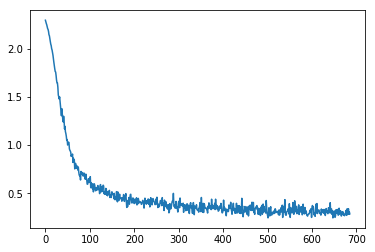

In [57]:
run.recorder.plot_loss()

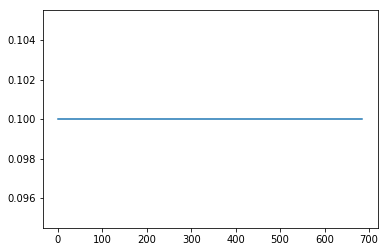

In [58]:
run.recorder.plot_lr()

As you can see, the learning rate didn't change during training, because we never told it to. Probably it is a good idea to have some kind of schedule for our learning rate. It's a great idea, which we will implement in the next post *(Link to scheduler post: Coming soon)*. 

### Wrapup

In this post, we started with raw pytorch and wrote a bunch of convienient classes to wrap our data `DataBunch`, Learnt about callbacks in Python, Wrote a very flexible training loop, implemented couple of callbacks to report metrics and plot losses. We will build on these classes as we continue studying more topics in deep learning.

If you made it till here, well done !!!. We have made our life super easy going forward. This investment will allow us to focus on other fun stuff such as designing better architectures, studying better optimizers, better scheduling of our hyperparameters and much more.

> **Note**: This post `heavily borrows (almost everything)` from first 2 lectures of [fast.ai](https://www.fast.ai/) part2 2019. This course hasn't been officially released. Tentative release date June 2019.

### Export as Module

In [60]:
!python notebook2script.py 00_data.ipynb

Converted 00_data.ipynb to fastlib/nb_00.py
